In [1]:
import os
from dotenv import load_dotenv

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_groq import ChatGroq
from langchain_qdrant import QdrantVectorStore
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import trim_messages, BaseMessage, HumanMessage, ToolMessage
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory

from langgraph.graph import END, START, StateGraph

In [2]:

load_dotenv()


True

In [3]:

PROMPT_TEMPLATE = """
Answer the question  or check the correctness of the response based on the following context:

{context}

----
Use latex formatting for equations. Enclose equations in $ sign.
Use markdown formatting for everything else.
Here's the user input: {query}
----
If this is a question answer the question, if this is an attempt to answer a previous question, check if the answer is correct.
"""

SUMMARIZATION_PROMPT="""
You are a summarizer of text tasked with summarizing the chat conversation between a student and a teaching assistant.
Present in the conversation are also thoughts of the teaching assistant on how to answer the student's queries which are
filtered in the actual conversation because the assistant wants to help the student arrive at the answer themselves instead
of simply giving the answer.
Here is the summary of their conversation so far, the assistant's extra thoughts and the last couple of messages exchanged:

{context}


Summarize this conversation so that another teaching assistant could read it and understand the problem the student is facing,
how to solve the problem, and the progress of the student so far. They should be able to get all the context necessary to
begin helping the student from your summary.
Be concise and only include details of the actual conversation.
"""

SOCRATIC_PROMPT_TEMPLATE="""
You are a tutor trying to help a student learn a concept. You are helping them with a problem and want to help
them understand the concepts by figuring out the solution themselves with only small nudges in the right direction.

Here's the summary of the entire conversation with them so far, along with additional context to solve the problem (the
additional context is not visible to the student). The summary: 
------------------------------

{context}

------------------------------
Here's the student's most recent response: {query}


Based on the solution to the question, use the socratic method to guide the student towards the answer.
Do no answer the question, but provide hints or prompt the student to think of the next step.
"""

In [4]:
import vertexai
from langchain_google_vertexai import VertexAIEmbeddings

def get_vertex_embeddings():
    vertexai.init(
        project=os.environ.get("VERTEX_PROJECT_ID"),
        location=os.environ.get("VERTEX_PROJECT_LOCATION")
        )

    # Initialize the a specific Embeddings Model version
    embeddings = VertexAIEmbeddings(model_name="text-embedding-004")
    
    return embeddings

In [5]:
def get_vector_retriever():
    QDRANT_URL=os.environ.get("QDRANT_URL")
    QDRANT_API_KEY=os.environ.get("QDRANT_API_KEY")
    vectorstore = QdrantVectorStore.from_existing_collection(
        collection_name="dsa_notes",
        embedding=get_vertex_embeddings(),
        url=QDRANT_URL,
        api_key=QDRANT_API_KEY,
    )
    return vectorstore.as_retriever(k=2)

retriever = get_vector_retriever()


In [6]:
from langchain_google_vertexai import ChatVertexAI
MODEL_ID="gemini-1.5-flash-001"
PROJECT_ID="streamlit-app-434805"
REGION="asia-south1"
llm2 = ChatVertexAI(model_name=MODEL_ID, location=REGION, project=PROJECT_ID)

llm2.invoke("hi")

I0000 00:00:1726209492.763956  233181 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers


AIMessage(content='Hi there! 👋  What can I do for you today? 😊 \n', response_metadata={'is_blocked': False, 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability_label': 'NEGLIGIBLE', 'blocked': False, 'severity': 'HARM_SEVERITY_NEGLIGIBLE'}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability_label': 'NEGLIGIBLE', 'blocked': False, 'severity': 'HARM_SEVERITY_NEGLIGIBLE'}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability_label': 'NEGLIGIBLE', 'blocked': False, 'severity': 'HARM_SEVERITY_NEGLIGIBLE'}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability_label': 'NEGLIGIBLE', 'blocked': False, 'severity': 'HARM_SEVERITY_NEGLIGIBLE'}], 'usage_metadata': {'prompt_token_count': 1, 'candidates_token_count': 16, 'total_token_count': 17, 'cached_content_token_count': 0}, 'finish_reason': 'STOP'}, id='run-8f2232cf-e404-430c-8e79-c7fa11fb5112-0', usage_metadata={'input_tokens': 1, 'output_tokens': 16, 'total_tokens': 17})

In [7]:
from pydantic import BaseModel, Field
from typing import Literal

llm = ChatOpenAI()

# Router
class CheckContext(BaseModel):
    binary_score: Literal["yes", "no"] = Field(
        description="Is the context enough to provide a response to the student's query? 'yes' or 'no'"
    )

# LLM with router output
llm_router = llm.with_structured_output(CheckContext)

# Prompt
system_router = """
You are a reasoning agent checking if the provided context is enough to answer a student's
query. The query can be a question: if so you must check if the context is enough to
answer the question. The query can also be a student's attempt at answering or taking the
next step in answering a question: if so, you must check if the context is enough to
check the student's response for correctness and be able to guide them towards the right
path. Give a binary score 'yes' or 'no' to indicate whether the context is enough 
for the task. If responding to either type of query requires performing new arithematic
not present in the context, score 'no'.
"""

prompt_router = ChatPromptTemplate.from_messages(
    [
        ('system', system_router),
        ('human', "Context: \n\n {context} \n\n Student query: {query}"),
    ]
)

router = prompt_router | llm_router
query = "what is the quicksort?"
docs = retriever.invoke(query)
doc_text = docs[1].page_content
print(router.invoke({'context': doc_text, 'query': query}))

binary_score='yes'


In [8]:
prompt_socratic = ChatPromptTemplate.from_template(SOCRATIC_PROMPT_TEMPLATE)
socratic = prompt_socratic | llm | StrOutputParser()
print(socratic.invoke({'context': doc_text, 'query': query}))

It seems like you are on the right track with understanding how quicksort works. Can you think about how the partitioning step helps in sorting the elements? Consider how the pivot element is chosen and how it divides the array into smaller subarrays.


In [9]:
prompt_summary = ChatPromptTemplate.from_template(SUMMARIZATION_PROMPT)
summary = prompt_summary | llm | StrOutputParser()

In [10]:
summary.invoke({'context': query + socratic.invoke({'context': doc_text, 'query': query})})

"The student is asking about quicksort and seems to understand the partitioning step. They are asked to think about how quicksort builds a recursion tree and how pivot element selection impacts the tree's height. The student is prompted to consider repeatedly picking the median element as the pivot during partitioning and its effect on subproblem sizes. The student needs to think about how this affects the recursion tree's levels."

In [11]:
context_of_no_consequence = query + socratic.invoke({'context': doc_text, 'query': query})

In [12]:
summary.invoke({'context': context_of_no_consequence})

'The student is trying to understand quicksort and has a grasp on the partitioning step. The teaching assistant is guiding them to think about how the entire quicksort algorithm works, including recursion and pivot element choice. The student is making progress in understanding quicksort but still needs help with recursion and pivot element choice. The assistant is encouraging the student to think critically about these aspects.'

In [13]:
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
import requests
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults

@tool
def wolfram_call(query: str) -> str:
    """Calls the wolfram alpha api on query.

    Args:
        query (str): The query to use as a parameter in the function call. For example, "Solve 3x=5"

    Returns:
        str: Returns the result of the api call on the query.
    """
    params = {
        "input": query,
        "appid": os.environ.get("WOLFRAM_ALPHA_APPID"),
        "format": "plaintext",
        "output": "json",
    }
    response = requests.get("https://api.wolframalpha.com/v2/query", params=params)
    full_response = response.json()
    pods = [x["subpods"] for x in full_response["queryresult"]["pods"]]
    return str(pods)

repl = PythonREPL()

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."]
):
    """Use this to execute python code. If you want to see the output of a value, you
    should print it out with `print(...)`. This is visible to the student.

    Args:
        code (Annotated[str, &quot;The python code to execute to generate your chart.&quot;]): The python code to execute
    """
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n ```python\n{code}\n```\nStdout: {result}"
    return result_str

@tool
def notes_search(query: str) -> str:
    """Calls the vector database of data stuctures and algorithm notes to get any definitions, theorems, axioms, proofs, examples, information for summarizing.
    The database contain notes for . It covers the following topics:
    limits, derivatives, derivative applications, integrals, integral applications, integration techniques, more integral applications, parametric and polar, series and sequences, vectors, 3-d space, partial derivatives, applications of partial derivatives, multiple integrals, line integrals, surface integrals, various calculus proofs, review of trignometry and functions.

    Args:
        query (str): the query sent to the vector database.

    Returns:
        str: Returns the documents retrieved from the vector database based on the query.
    """
    return retriever.invoke(query)

web_search = TavilySearchResults(max_results=2)

tools = [wolfram_call, python_repl, notes_search, web_search]

In [14]:
from typing import Sequence, TypedDict
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    query: str
    context: str
    solved: str
    response: str = ""

In [15]:
import functools

from langchain_core.messages import AIMessage
from langgraph.prebuilt import create_react_agent

CALCULUS_PROMPT="""You are a teaching assistant helping a student solve calculus problmes.
Here is a summary of your conversation with the student so far:

{context}

Here is the student's most recent response: {query}

If the student asked a new question, solve it completely. If the student responded with
their solution, check if it is correct. You have a number of tools available for this task:
notes_search: search through calculus 1,2 and 3 university notes,
web_search: search the web for facts and information not found in the notes,
wolfram_call: a very powerful calculator,
python_repl: a python interpreter that can be used to solve math problems or create graphs to help the student visualize the solution better.
Use any of these as many times as needed to solve the problem as accurately as possible. 
Be concise in your solution.
"""

prompt_test = ChatPromptTemplate.from_template(CALCULUS_PROMPT)
solver = prompt_test | llm.bind_tools(tools)
print(solver.invoke({'context': '', 'query': query}))

content='' additional_kwargs={'tool_calls': [{'id': 'call_dAqS7R9Xc5TXhjjiOgcrwRa0', 'function': {'arguments': '{"query":"quicksort"}', 'name': 'notes_search'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 595, 'total_tokens': 611, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None} id='run-d9577bda-3031-43ce-b819-68ab54f39b91-0' tool_calls=[{'name': 'notes_search', 'args': {'query': 'quicksort'}, 'id': 'call_dAqS7R9Xc5TXhjjiOgcrwRa0', 'type': 'tool_call'}] usage_metadata={'input_tokens': 595, 'output_tokens': 16, 'total_tokens': 611}


In [33]:
# convert chains to nodes
def router_node(state: AgentState):
    if 'yes' in  router.invoke({'context': state['context'], 'query': state['query']}):
        state["solved"] = 'yes'
    else:
        state["solved"] = 'no'
    return state
        
def socratic_node(state: AgentState):
    state["response"] = socratic.invoke({'context': state['context'], 'query': state['query']})
    return state

def solver_node(state: AgentState):
    state['context'] += solver.invoke({'context': state['context'], 'query': state['query']}).content
    return state
def summary_node(state: AgentState):
    state['context'] = summary.invoke({'context': state['context'] + state['query'] + state['response']})
    return state
    

In [34]:
workflow = StateGraph(AgentState)

workflow.add_node("router", router_node)
workflow.add_node("socratic", socratic_node)
workflow.add_node("solver", solver_node)
workflow.add_node("summary", summary_node)

workflow.set_entry_point("router")
workflow.add_conditional_edges(
    "router",
    lambda x: x['solved'],
    {
        "yes": "socratic",
        "no": "solver",
    },
)
workflow.add_edge("solver", "socratic")
workflow.add_edge("socratic", "summary")
workflow.add_edge("summary", END)

graph = workflow.compile()

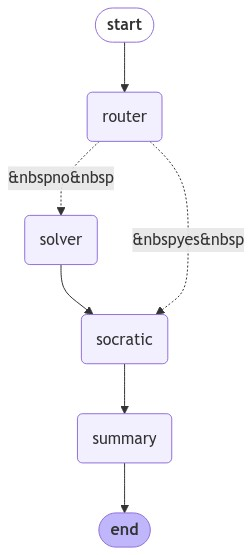

In [35]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [36]:
from langchain_core.messages import BaseMessage

query = "What is quicksort?"


In [41]:
for event in graph.stream({"query": query, "context": "", "response": "", "solved": ""}):
    for value in event.values():
        print("Content:", value["context"])
        print("Response:", value["response"])
            # print("Assistant:", value["response"].content)

Content: 
Response: 
Content: 
Response: 
Content: 
Response: Great question! Let's break it down. Have you heard of sorting algorithms before? Let's start by discussing the concept of sorting and why it's important in computer science.
Content: The student asked about quicksort and the teaching assistant guided them by discussing sorting algorithms and why they are important in computer science. The assistant is helping the student arrive at the answer themselves rather than giving it directly. The student seems to be progressing well in understanding the concept.
Response: Great question! Let's break it down. Have you heard of sorting algorithms before? Let's start by discussing the concept of sorting and why it's important in computer science.
